In [6]:
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
# current_dir = '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18'
# parent_dir = '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux'
# sys.path.insert(0, current_dir)
# sys.path.insert(0, parent_dir)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
import time
import os
import copy
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from tensorboardX import SummaryWriter
from tqdm import tqdm

print(sys.path)

from models.model_RCNN_only import RCNN_only
from dataset_cvpr import SUN360Horizon, pitch_bins_centers, roll_bins_centers, vfov_bins_centers, my_collate_SUN360
from compute_vectors import generate_field
from maskrcnn_rui.data.transforms import build_transforms_maskrcnn, build_transforms_yannick

from maskrcnn_rui.config import cfg

from eval_epoch_cvpr_RCNN import eval_epoch_cvpr_RCNN
import utils.model_utils as model_utils
from utils.logger import setup_logger, printer
from utils.train_utils import *
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from utils.checkpointer import DetectronCheckpointer

from utils.data_utils import make_data_loader, train_trnfs_yannick, eval_trnfs_yannick
import maskrcnn_benchmark

from utils.eval_save_utils_combine_RCNNONly import check_save
from utils.utils_misc import *
import utils.vis_utils as vis_utils
import apex

from utils.eval_save_utils_combine_RCNNONly import check_vis_SUN360


parser = argparse.ArgumentParser(description="Rui's Scale Estimation Network Training")
# Training
parser.add_argument('--task_name', type=str, default='tmp', help='resume training')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=8)
parser.add_argument('--batchsize', type=int, default=36, help='input batch size during training')
parser.add_argument('--save_every_iter', type=int, default=0, help='set to 0 to save ONLY at the end of each epoch')
# parser.add_argument('--batchsizeeval', type=int, default=42, help='input batch size during evaluation')
parser.add_argument('--niter', type=int, default=5000, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate, default=0.005')
parser.add_argument('--beta1', type=float, default=0.9, help='beta1 for adam. default=0.5')
parser.add_argument('--not_val', action='store_true', help='Do not validate duruign training')
parser.add_argument('--save_every_epoch', type=int, default=10, help='save checkpoint every ? epoch')
# Model
parser.add_argument('--accu_model', action='store_true', help='Use accurate model with theta instead of Derek\'s approx.')
# Pretraining
parser.add_argument('--resume', type=str, help='resume training; can be full path (e.g. tmp/checkpoint0.pth.tar) or taskname (e.g. tmp)', default='NoCkpt')
parser.add_argument('--feature_only', action='store_true', help='restore only features (remove all classifiers) from checkpoint')
# Device
parser.add_argument('--cpu', action='store_true', help='Force training on CPU')
parser.add_argument("--local_rank", type=int, default=0)
parser.add_argument("--master_port", type=str, default='8914')
# DEBUG
parser.add_argument('--debug', action='store_true', help='Debug eval')
# Mask R-CNN
parser.add_argument('--not_rcnn', action='store_true', help='Disable Mask R-CNN module')

parser.add_argument('--pointnet_camH', action='store_true', help='')
parser.add_argument('--est_bbox', action='store_true', help='Enable estimating bboxes instead of using GT bboxes')



parser.add_argument(
    "--config-file",
    default="",
    metavar="FILE",
    help="path to config file",
    type=str,
)
parser.add_argument(
    "opts",
    help="Modify config options using the command-line",
    default=None,
    nargs=argparse.REMAINDER,
)

# opt = parser.parse_args()
opt = parser.parse_args('--batchsize=1 --task_name tmp_eval --niter 1 --accu_model --resume YES \
--config-file /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/coco_config_small_RCNNOnly.yaml \
SOLVER.IMS_PER_BATCH 1 TEST.IMS_PER_BATCH 1'.split())

opt.checkpoints_folder = '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint'

# config_file = "maskrcnn/coco_config.yaml"
config_file = opt.config_file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])
cfg.merge_from_list(opt.opts)
cfg.freeze()
opt.cfg = cfg

# === DISTRIBUTED TRAINING
num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
opt.distributed = num_gpus > 1
if opt.distributed:
    torch.cuda.set_device(opt.local_rank)
    torch.distributed.init_process_group(
        backend="nccl", init_method="env://"
    )
    synchronize()
# device = torch.device("cuda" if torch.cuda.is_available() and not opt.cpu else "cpu")
device = 'cuda'
print("Device:", device)
rank = get_rank()

# === SUMMARY WRITERS
summary_path = './summary/'+opt.task_name
writer = SummaryWriter(summary_path)

# === LOGGING
# sys.stdout = Logger(summary_path+'/log.txt')
logger = setup_logger("logger:train", summary_path, get_rank(), filename="logger_maskrcn-style.txt")
logger.info(colored("==[config]== opt", 'white', 'on_blue'))
logger.info(opt)
logger.info(colored("==[config]== cfg", 'white', 'on_blue'))
logger.info(cfg)
logger.info(colored("==[config]== Loaded configuration file {}".format(opt.config_file), 'white', 'on_blue'))
with open(opt.config_file, "r") as cf:
    config_str = "\n" + cf.read()
    logger.info(config_str)
printer = printer(get_rank(), debug=opt.debug)

['/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/panorama_cropping_dataset_generation', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/panorama_cropping_dataset_generation', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18', '/home/ruizhu/anaconda3/envs/yannick_docker_py36/lib/python36.zip', '/home/ruizhu/anaconda3/envs/yannick_docker_py36/lib/python3.6', '/home/ruizhu/anaconda3/envs/yannick_docker_py36/lib/python3.6/lib-dynlo

logger:train INFO: Namespace(accu_model=True, batchsize=1, beta1=0.9, cfg=CfgNode({'MODEL': CfgNode({'RPN_ONLY': False, 'MASK_ON': False, 'RETINANET_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'NAME': '', 'META_ARCHITECTURE': 'GeneralizedRCNNRui', 'CLS_AGNOSTIC_BBOX_REG': False, 'WEIGHT': '', 'RCNN_WEIGHT': '', 'RCNN_WEIGHT_BACKBONE': '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth', 'RCNN_WEIGHT_BOX_HEAD': '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth', 'RCNN_WEIGHT_KPS_HEAD': '', 'RCNN_WEIGHT_CLS_HEAD': '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth', 'DENSENET_WEIGHT': 'model_best.pth.tar', 'LOSS': CfgNode({'VT_LOSS_CLAMP': 10.0}), 'BACKBONE': CfgNode({'CONV_BODY': 'FBNet', 'FREEZE_CONV_BODY_AT': 2}), 'FPN': CfgNode({'USE_GN': False, 'USE_REL

logger:train INFO: ==[config]== cfg
logger:train INFO: ==[config]== cfg
logger:train INFO: ==[config]== cfg
logger:train INFO: AMP_VERBOSE: False
DATA:
  COCO:
    CLIP_N_IN_MASKRCNN: False
    COCO_SUBSET: coco_scale_eccv
    GOOD_NUM: 10
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  NUM_WORKERS: 4
  SIZE_DIVISIBILITY: 32
DATASETS:
  TEST: ()
  TRAIN: ()
DTYPE: float32
INPUT:
  BRIGHTNESS: 0.2
  CONTRAST: 0.2
  HORIZONTAL_FLIP_PROB_TRAIN: 0.0
  HUE: 0.1
  MAX_SIZE_TEST: 1000
  MAX_SIZE_TRAIN: 1000
  MIN_SIZE_TEST: 600
  MIN_SIZE_TRAIN: (600,)
  PIXEL_MEAN: [103.53, 116.28, 123.675]
  PIXEL_STD: [57.375, 57.12, 58.395]
  SATURATION: 0.2
  TO_BGR255: True
  VERTICAL_FLIP_PROB_TRAIN: 0.0
MODEL:
  BACKBONE:
    CONV_BODY: FBNet
    FREEZE_CONV_BODY_AT: 2
  CAR:
    MEAN: 1.59
    STD: 0.21
  CLASSIFIER_HEAD:
    FEATURE_EXTRACTOR: FBNet.roi_head
    NUM_CLASSES: 256
    POOLER_RESOLUTION: 6
    POOLER_SAMPLING_RATIO: 2
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    PREDICTOR: FCPredi

logger:train INFO: AMP_VERBOSE: False
DATA:
  COCO:
    CLIP_N_IN_MASKRCNN: False
    COCO_SUBSET: coco_scale_eccv
    GOOD_NUM: 10
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  NUM_WORKERS: 4
  SIZE_DIVISIBILITY: 32
DATASETS:
  TEST: ()
  TRAIN: ()
DTYPE: float32
INPUT:
  BRIGHTNESS: 0.2
  CONTRAST: 0.2
  HORIZONTAL_FLIP_PROB_TRAIN: 0.0
  HUE: 0.1
  MAX_SIZE_TEST: 1000
  MAX_SIZE_TRAIN: 1000
  MIN_SIZE_TEST: 600
  MIN_SIZE_TRAIN: (600,)
  PIXEL_MEAN: [103.53, 116.28, 123.675]
  PIXEL_STD: [57.375, 57.12, 58.395]
  SATURATION: 0.2
  TO_BGR255: True
  VERTICAL_FLIP_PROB_TRAIN: 0.0
MODEL:
  BACKBONE:
    CONV_BODY: FBNet
    FREEZE_CONV_BODY_AT: 2
  CAR:
    MEAN: 1.59
    STD: 0.21
  CLASSIFIER_HEAD:
    FEATURE_EXTRACTOR: FBNet.roi_head
    NUM_CLASSES: 256
    POOLER_RESOLUTION: 6
    POOLER_SAMPLING_RATIO: 2
    POOLER_SCALES: (0.25, 0.125, 0.0625, 0.03125)
    PREDICTOR: FCPredictorRui
  CLS_AGNOSTIC_BBOX_REG: False
  DENSENET_WEIGHT: model_best.pth.tar
  DEVICE: cuda
  FBNET:
    ARC

logger:train INFO: 
# Based on https://github.com/facebookresearch/maskrcnn-benchmark/blob/464b1af167d3dcb513964e62389825ff507609c3/configs/e2e_faster_rcnn_fbnet_chamv1a_600.yaml

MODEL:
  META_ARCHITECTURE: "GeneralizedRCNNRui"
#  RCNN_WEIGHT: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
  RCNN_WEIGHT_BACKBONE: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
#  RCNN_WEIGHT_BACKBONE: "1105Morning-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDist_fix_bs16on4_le5e-3_unfreeezeFeat_indeptClsHeads"
  RCNN_WEIGHT_BOX_HEAD: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
#  RCNN_WEIGHT_BOX_HEAD: "1105Morning-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDist_fix_bs16on4_le5e-3_unfreeezeFeat_indeptClsHeads"
  RCNN_WEIGHT_CLS_HEAD: "/home/ruizhu/Documents/Projects/ado

In [7]:
resume_task_name = '1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug'

model = RCNN_only(cfg, opt, logger, printer, rank=rank)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg.SOLVER.BASE_LR, betas=(opt.beta1, 0.999), eps=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20, cooldown=10)

save_to_disk = get_rank() == 0
opt.checkpoints_folder = current_dir + '/checkpoint'
checkpointer = DetectronCheckpointer(
    opt, model, optimizer, scheduler, opt.checkpoints_folder, os.path.join(opt.checkpoints_folder, resume_task_name), save_to_disk, logger=logger
)
checkpoint_restored, _, _ = checkpointer.load(task_name=resume_task_name)

logger:train INFO: Using 'latest checkpoint' from task 1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug...; at /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth
logger:train INFO: Using 'latest checkpoint' from task 1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug...; at /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth
logger:train INFO:

logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              of shape (32,)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              of shape (32,)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pw.bn.bias                                                              of shape (32,)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pw.bn.num_batches_tracked          

logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pwl.bn.weight                                                           of shape (24,)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pwl.conv.weight                                                         of shape (24, 32, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pwl.conv.weight                                                         of shape (24, 32, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif0_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif0_0.pwl.conv.weight  

logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_var                 

logger:train WARNING: RCNN.backbone.body.stages.xif1_1.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif1_1.pw.conv.weight                                                          of shape (192, 48, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif1_1.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif1_1.pw.conv.weight                                                          of shape (192, 48, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif1_1.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif1_1.pwl.bn.bias                                                             of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_1.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif1_1.pwl.bn.bias    

logger:train WARNING: RCNN.backbone.body.stages.xif2_0.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif2_0.pw.bn.running_mean                                                      of shape (336,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_0.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_0.pw.bn.running_var                                                       of shape (336,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_0.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_0.pw.bn.running_var                                                       of shape (336,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_0.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_0.pw.bn.running_var               

logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.num_batches_tracked       

logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pwl.bn.weight                                                           of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pwl.conv.weight                                                         of shape (64, 448, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pwl.conv.weight                                                         of shape (64, 448, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pwl.conv.weight

logger:train WARNING: RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif2_2.pwl.bn.running_mean                                                     of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_2.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif2_2.pwl.bn.running_var                 

logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          of shape (448, 64, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          of shape (448, 64, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pwl.bn.bias                                                             of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pwl.bn.bias    

logger:train WARNING: RCNN.backbone.body.stages.xif2_4.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif2_4.pw.bn.running_mean                                                      of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_4.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_4.pw.bn.running_var                                                       of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_4.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_4.pw.bn.running_var                                                       of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_4.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_4.pw.bn.running_var               

logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              of shape (768,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              of shape (768,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pw.bn.bias                                                              of shape (768,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pw.bn.num_batches_tracked       

logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.bn.weight                                                           of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         of shape (56, 768, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         of shape (56, 768, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.conv.weight

logger:train WARNING: RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_1.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.pwl.bn.running_var                 

logger:train WARNING: RCNN.backbone.body.stages.xif3_10.pw.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_10.pw.conv.weight                                                         of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_10.pw.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_10.pw.conv.weight                                                         of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_10.pwl.bn.bias                                                            <<LOADED FROM<< RCNN.backbone.body.stages.xif3_10.pwl.bn.bias                                                            of shape (88,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_10.pwl.bn.bias                                                            <<LOADED FROM<< RCNN.backbone.body.stages.xif3_10.pwl.bn.bias   

logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_mean                                                     of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_var              

logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pw.bn.num_batches_tracked       

logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pwl.bn.weight                                                           of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pwl.conv.weight                                                         of shape (56, 672, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pwl.conv.weight                                                         of shape (56, 672, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_2.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_2.pwl.conv.weight

logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_var                 

logger:train WARNING: RCNN.backbone.body.stages.xif3_4.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_4.pw.conv.weight                                                          of shape (672, 56, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_4.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_4.pw.conv.weight                                                          of shape (672, 56, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_4.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif3_4.pwl.bn.bias                                                             of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_4.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif3_4.pwl.bn.bias    

logger:train WARNING: RCNN.backbone.body.stages.xif3_6.dw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.dw.conv.weight                                                          of shape (672, 1, 5, 5)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.bias              

logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pwl.bn.weight                                                           of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pwl.bn.weight                                                           of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pwl.conv.weight                                                         of shape (56, 672, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pwl.conv.weight          

logger:train WARNING: RCNN.backbone.body.stages.xif3_7.pwl.bn.num_batches_tracked                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_7.pwl.bn.num_batches_tracked                                              of shape ()
logger:train WARNING: RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                                                     of shape (88,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                                                     of shape (88,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_7.pwl.bn.running_mean                   

logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pwl.b

logger:train WARNING: RCNN.backbone.body.stages.xif3_9.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_9.pw.bn.running_mean                                                      of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_9.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_9.pw.bn.running_mean                                                      of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_9.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif3_9.pw.bn.running_var                                                       of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_9.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif3_9.pw.bn.running_var               

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.dw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.dw.conv.weight             of shape (616, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pw.bn.bias                 <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pw.bn.bias                 of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pw.bn.bias                 <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pw.bn.bias                 of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pw.bn.bias                 <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extracto

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.conv.weight            <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.b

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.running_mean        <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.running_mean        of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.pwl.bn.running_mean        <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xi

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.bn.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.bn.weight               of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.conv.weight             of shape (1064, 152, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.conv.weight             of shape (1064, 152, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_2.pw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.f

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_var          <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.hea

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.dw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.dw.conv.weight             of shape (1520, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.dw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.dw.conv.weight             of shape (1520, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.pw.bn.bias                 <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.pw.bn.bias                 of shape (1520,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_4.pw.bn.bias                 <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.featu

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.bn.weight                 <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.bn.weight                 of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               of shape (616, 88, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               of shape (616, 88, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean           of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_1.pw.bn.running_var            <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.dw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.dw.conv.weight               of shape (1064, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.dw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.dw.conv.weight               of shape (1064, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pw.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pw.bn.bias                   of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pw.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var           <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var           of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blo

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked   of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.pwl.bn.running_mean          <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.p

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                of shape (616, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                of shape (616, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.bias                    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.bias                    of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.bias                    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_ext

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.bias                   of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked    of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked    of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_1.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.b

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean            of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pwl.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_3.pwl.conv.weight               of shape (152, 1064, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.dw.conv.weight                of shape (1520, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.dw.conv.weight                of shape (1520, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_rol

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.bn.weight                  of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_0.pw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.bloc

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean            of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pwl.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_1.pwl.conv.weight               of shape (152, 1064, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                of shape (1064, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                of shape (1064, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfo

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var            of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                 <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.bloc

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.bias                   of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.bias                   of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked    of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_3.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.x

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.running_var             <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.running_var             of shape (1520,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  of shape (1520,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  of shape (1520,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.b

logger:train WARNING: ====== Successfully loaded 534 from 621 possible loads.
logger:train WARNING: ====== Successfully loaded 534 from 621 possible loads.
logger:train WARNING: ====== Successfully loaded 534 from 621 possible loads.
logger:train INFO: Loading optimizer from /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth
logger:train INFO: Loading optimizer from /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth
logger:train INFO: Loading optimizer from /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-r

In [13]:
# === DATASET
# from dataset import COCO2017Scale
from dataset_coco_pickle import COCO2017Scale, my_collate
from maskrcnn_rui.data.transforms import build_transforms_maskrcnn, build_transforms_yannick

# train_trnfs_maskrcnn = build_transforms_maskrcnn(cfg, True)
# eval_trnfs_maskrcnn = build_transforms_maskrcnn(cfg, False)
train_trnfs_maskrcnn = build_transforms_yannick(cfg, True)
eval_trnfs_maskrcnn = build_transforms_yannick(cfg, False)

ds_train_SUN360 = SUN360Horizon(transforms=train_trnfs_maskrcnn, train=True, logger=logger)
ds_eval_SUN360 = SUN360Horizon(transforms=eval_trnfs_maskrcnn, train=False, logger=logger)
training_loader_SUN360 = make_data_loader(
    cfg,
    ds_train_SUN360,
    is_train=True,
    is_distributed=opt.distributed,
    start_iter=0,
    logger=logger,
    collate_fn=my_collate_SUN360,
    override_shuffle=False,
)
eval_loader_SUN360 = make_data_loader(cfg, ds_eval_SUN360, is_train=False, is_distributed=opt.distributed, is_for_period=True, logger=logger, collate_fn=my_collate_SUN360, override_shuffle=False, batch_size_override=1)

# ds_train_coco = COCO2017Scale(transforms_yannick=eval_trnfs_yannick, transforms_maskrcnn=eval_trnfs_maskrcnn, split='train', shuffle=False, logger=logger, opt=opt) # !!!!!!!
# ds_eval_coco = COCO2017Scale(transforms_yannick=eval_trnfs_yannick, transforms_maskrcnn=eval_trnfs_maskrcnn, split='val', shuffle=False, logger=logger, opt=opt)
# training_loader_coco = make_data_loader(
#     cfg,
#     ds_train_coco,
#     is_train=True,
#     is_distributed=opt.distributed,
#     start_iter=0,
#     logger=logger,
#     override_shuffle=False,
#     collate_fn=my_collate,
# )
# eval_loader_coco = make_data_loader(cfg, ds_eval_coco, is_train=False, is_distributed=opt.distributed, is_for_period=True, logger=logger, override_shuffle=False, collate_fn=my_collate)

logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: ===== 397987 for the TRAIN set...
logger:train INFO: ===== 397987 for the TRAIN set...
logger:train INFO: ===== 397987 for the TRAIN set...
logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: [SUN360 dataset] Loaded 399987 images from /data/SUN360/crops_dataset_cvpr_myDistNarrowerLarge1105 in 0.10 seconds.
logger:train INFO: ===== 2000 f

# Eval SUN360

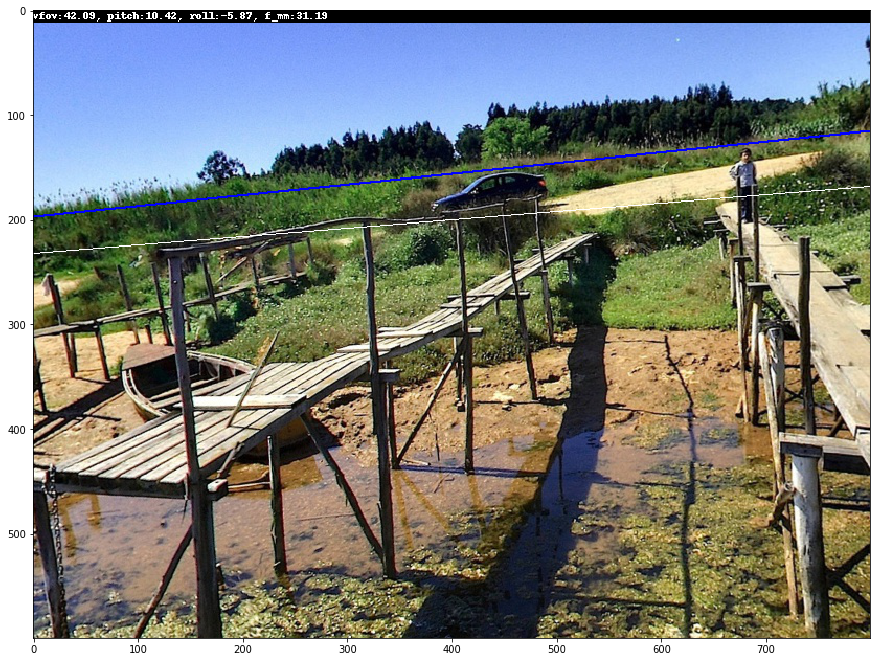

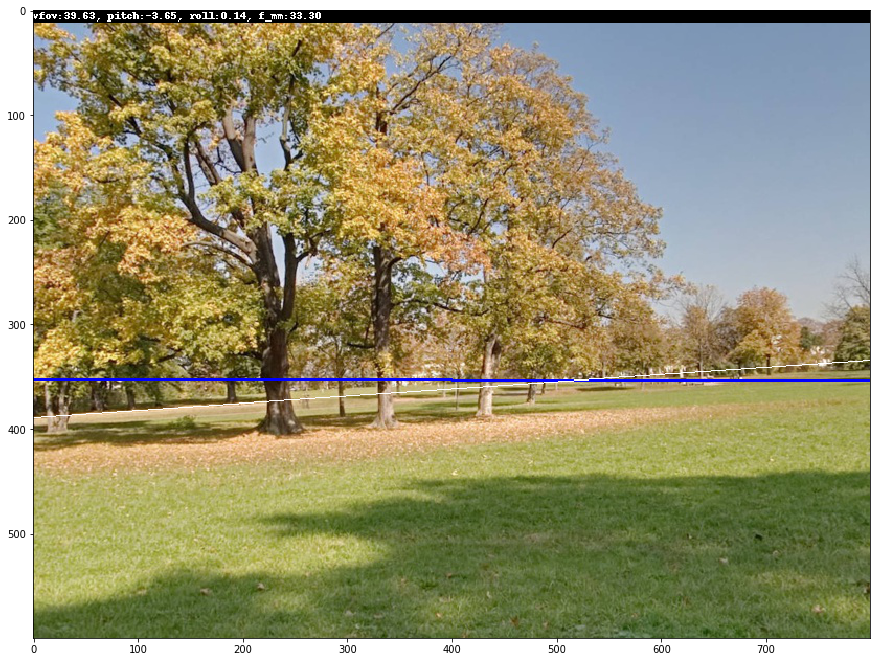

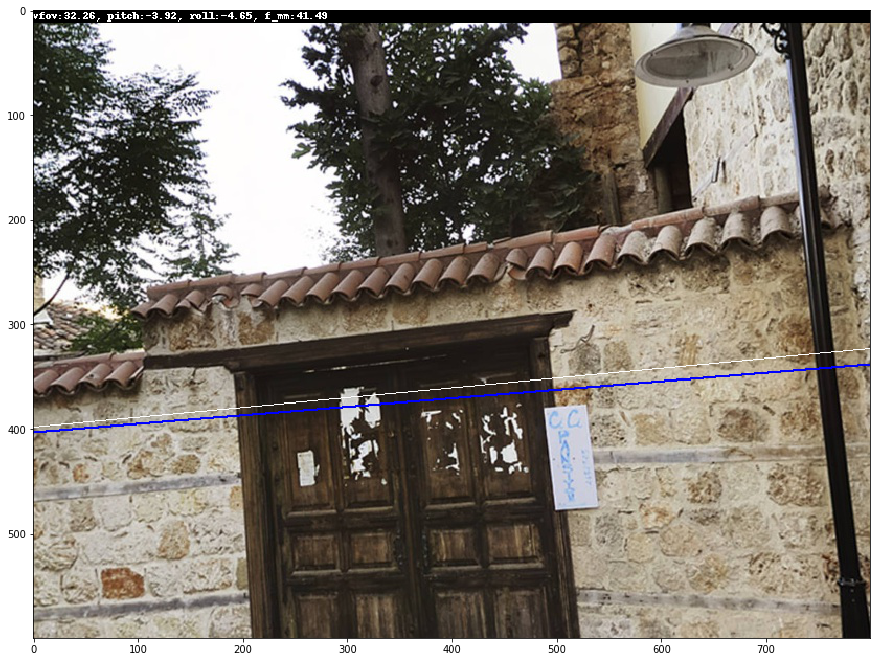

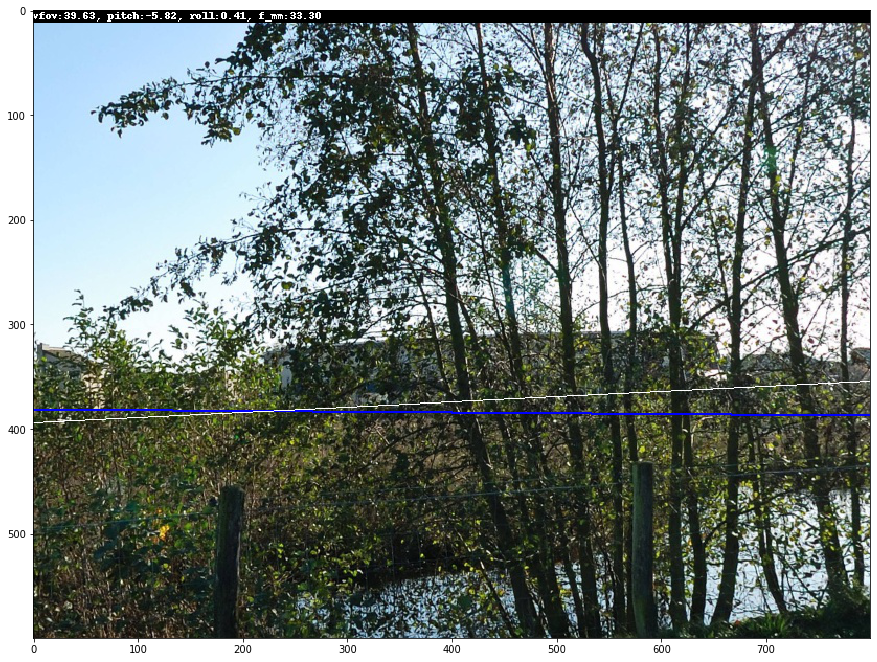

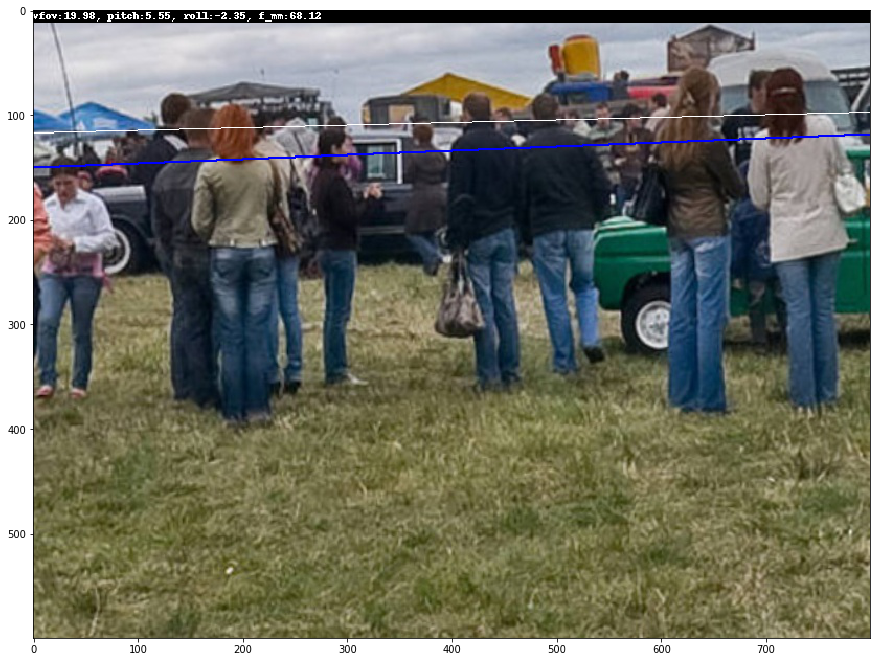

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io as io
from matplotlib.patches import Rectangle
import utils.utils_coco as utils_coco

from PIL import Image, ImageDraw, ImageFont
from imageio import imread, imsave

from panorama_cropping_dataset_generation.debugging import drawLine, showHorizonLine, showHorizonLineFromHorizon
from dataset_cvpr import bins2roll, bins2vfov, bins2horizon, bins2pitch
from utils.model_utils import get_bins_combine


test_loader = training_loader_SUN360

model.eval() #很关键！

with torch.no_grad():
    for i, (im_paths_SUN360, inputSUN360_Image_yannickTransform_list, \
                horizon_dist_gt, pitch_dist_gt, roll_dist_gt, vfov_dist_gt, metadata, \
                pitch_num, roll_num, vfov_num, horizon_num, focal_length_35mm_eq_num, sensor_size_num, W_num, H_num, idx1, idx2, idx3, idx4) in enumerate(test_loader):

        horizon_dist_gt, pitch_dist_gt, roll_dist_gt, vfov_dist_gt = horizon_dist_gt.to(device), pitch_dist_gt.to(device), roll_dist_gt.to(device), vfov_dist_gt.to(device)
        
        list_of_oneLargeBbox_list_cpu = model_utils.oneLargeBboxList(W_num, H_num)
        list_of_oneLargeBbox_list = [bbox_list_array.to(device) for bbox_list_array in list_of_oneLargeBbox_list_cpu]

        output_RCNN = model(image_batch_list=inputSUN360_Image_yannickTransform_list, list_of_oneLargeBbox_list=list_of_oneLargeBbox_list)
        output_horizon = output_RCNN['output_horizon']
        output_pitch = output_RCNN['output_pitch']
        output_roll = output_RCNN['output_roll']
        output_vfov = output_RCNN['output_vfov']

        idx = 0
        assert len(im_paths_SUN360)==1, 'len of im_paths_SUN360 is %d'%len(im_paths_SUN360)

        im = Image.fromarray(imread(im_paths_SUN360[idx])[:,:,:3])
        if len(im.getbands()) == 1:
            im = Image.fromarray(np.tile(np.asarray(im)[:,:,np.newaxis], (1, 1, 3)))

        horizon_disc = output_horizon[idx].detach().cpu().numpy().squeeze()
        pitch_disc = output_pitch[idx].detach().cpu().numpy().squeeze()
        roll_disc = output_roll[idx].detach().cpu().numpy().squeeze()
        vfov_disc = output_vfov[idx].detach().cpu().numpy().squeeze()
        # distortion_disc = distortion_disc.detach().cpu().numpy().squeeze()
        vfov_disc[...,0] = -35
        vfov_disc[...,-1] = -35

        horizon = bins2horizon(horizon_disc)
        pitch = bins2pitch(pitch_disc)
        roll = bins2roll(roll_disc)
        vfov = bins2vfov(vfov_disc)
        h, w = im.size
        f_pix = h / 2. / np.tan(vfov / 2.)
        sensor_size = sensor_size_num[idx]
        # sensor_size = 24 # !!!!!!
        f_mm = f_pix / h * sensor_size

        # horizon_from_pitch = 0.5 - 0.5*np.tan(pitch) / np.tan(vfov/2)

        im2, _ = showHorizonLine(np.asarray(im).copy(), vfov, pitch, roll, focal_length=f_mm, debug=True, color=(0, 0, 255), width=3) # Blue: horizon converted from camera params with roll
#         im2, _ = showHorizonLine(im2, vfov, pitch, 0., focal_length=f_mm, debug=True, color=(0, 0, 255), width=4) # Blue: horizon converted from camera params with roll
#         im2 = showHorizonLineFromHorizon(im2, horizon, color=(255, 255, 0), width=4) # Yellow: est horizon

        horizon_gt = horizon_num[idx]
        pitch_gt = pitch_num[idx]
        roll_gt = roll_num[idx]
        vfov_gt = vfov_num[idx]
        f_gt = focal_length_35mm_eq_num[idx]
#         im2 = showHorizonLineFromHorizon(im2, horizon_gt, color=(255, 255, 255), width=3) # White: GT horizon
        im2, _ = showHorizonLine(im2, vfov_gt, pitch_gt, roll_gt, focal_length=f_gt, debug=False, color=(255, 255, 255), width=1) # White: GT horizon with roll

#         if if_save:
#             prefix, postfix = prepostfix.split('|')
#             im_save_path = os.path.join(save_path, prefix+'tid%d-rank%d-idx%d'%(tid, rank, idx) + postfix + '-' +ntpath.basename(im_paths[idx])+'-f%.2f-GT%.2f.jpg'%(f_mm, f_gt))
#             imsave(im_save_path, im2)
#             print('Saved to ' + im_save_path)

        plt.figure(figsize=(15, 15))
        plt.imshow(im2)
        plt.show()
        plt.close()
        
#         break
        if i > 3:
            break